In [1]:
import json

import numpy as np
import torch
from torchvision import models

import shap

In [3]:
a = [87.24, 86.17, 86.26, 85.99, 87.15, 86.98, 86.80, 86.62, 86.44, 87.06]
print(np.mean(a), np.std(a))

86.671 0.4190811377287225


In [ ]:
import time
start_time = time.time()
retrain_model_eff(name='eff-L1-13', layid = 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [2]:
import os
# import cv2

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
# Create a custom dataset class
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torchvision
from torchvision import models
import os
from glob import glob
import pandas as pd

from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision import  transforms
import numpy as np


In [8]:
lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

In [3]:
IMG_SIZE = 256
transform_train = transforms.Compose(
[
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),  # Data augmentation: horizontal flip
        transforms.RandomRotation(10),  # Data augmentation: random rotation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
transform_val = transforms.Compose(
[
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


In [10]:
def _get_df_test_data_():
    train_df = pd.read_csv('/kaggle/input/ucidatasplits/train_df.csv').drop(columns=['Unnamed: 0'])
#     val_df = pd.read_csv('/kaggle/input/ucidatasplits/val_df.csv').drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv('/kaggle/input/ucidatasplits/test_df.csv').drop(columns=['Unnamed: 0'])
    source = '/kaggle/input/skin-cancer-mnist-ham10000/'

    train_df['image'] = train_df['path'].map(lambda x: transform_train(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
#     val_df['image'] = val_df['path'].map(lambda x: transform_val(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
    test_df['image'] = test_df['path'].map(lambda x: transform_val(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
    
    return train_df, test_df

In [13]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models

# Define the MLP
from torchvision.models import ResNet18_Weights
from transformers import ViTForImageClassification, ViTFeatureExtractor

class ImageEffNet(nn.Module):
    def __init__(self, output_size, num_classes):
        super(ImageEffNet, self).__init__()
        self.net = models.efficientnet_b0(weights='DEFAULT')
        self.net.classifier[1] = nn.Linear(self.net.classifier[1].in_features, output_size)
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x
    
def _get_model_Eff():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    unet = ImageEffNet(output_size, num_classes)
    return unet

In [13]:
train_df, test_df = _get_df_test_data_()

In [15]:
class dataMedicalImage(Dataset):
    def __init__(self, dataframe, image_folder=None, transform=None):
        self.dataframe = dataframe
        self.folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['cell_type_idx']  # Assuming the label is in the second column
        
        return image, int(label)

In [9]:
label_dict = {
    'nv': 4,      # Melanocytic nevi
    'mel': 5,     # Melanoma
    'bkl': 2,     # Benign keratosis-like lesions
    'bcc': 1,     # Basal cell carcinoma
    'akiec': 0,   # Actinic keratoses
    'vasc': 6,    # Vascular lesions
    'df': 3       # Dermatofibroma
}
class_names=['akiec', 'bcc','bkl', 'df', 'nv', 'mel', 'vasc']

In [33]:
class_names[0]

'akiec'

In [16]:
model_eff = _get_model_Eff()
    # retune the first one
model_path= '/kaggle/input/tunedmodel/eff_combine_model_tune.pt'
model_eff.load_state_dict(torch.load(model_path)) # , map_location='cpu'
    
image_source = '/kaggle/input/skin-cancer-mnist-ham10000/'
train_data = dataMedicalImage(train_df, image_folder= image_source, transform=transform_train)
test_data = dataMedicalImage(test_df, image_folder= image_source, transform=transform_val)
    
trainloader = DataLoader(dataset=train_data, batch_size=train_df.shape[0], shuffle=False)
testloader = DataLoader(test_data, batch_size=2, shuffle=False)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [17]:
dat = iter(trainloader)
imageX, labely = next(dat)

In [12]:
import numpy as np

# Assuming imageX is your 3D image data with shape [5229, 3, 244, 244]
# Randomly select 700 indices from the range 0 to 5228 (inclusive)
random_indices = np.random.choice(imageX.shape[0], size=28, replace=False)

# Select the corresponding data using the random indices
selected_images = imageX[random_indices]

# The shape of selected_images should be [700, 3, 244, 244]
print(selected_images.shape)

torch.Size([28, 3, 256, 256])


1. 94 HAM_0001465 ISIC_0032699 mel ear \\
1. 450 HAM_0006437 ISIC_0033469 mel ear \\
1. 647 HAM_0005084 ISIC_0028505 mel ear \\
1. 111 HAM_0005504 ISIC_0027480 mel foot
1. 789 HAM_0006223 ISIC_0025791 mel foot
1. 1002 HAM_0006923 ISIC_0032592 mel foot
1. 2     HAM_0005275  ISIC_0028749    bkl         face
1. 8     HAM_0001460  ISIC_0025637  akiec         face
1. 21    HAM_0004472  ISIC_0025368  akiec         face
1. 136   HAM_0001743  ISIC_0030130    bkl         hand
1. 227   HAM_0006213  ISIC_0025182  akiec         hand
1. 509   HAM_0004832  ISIC_0024709    bkl         hand

In [12]:
image_ids_to_find = ['ISIC_0032699', 'ISIC_0033469', 'ISIC_0028505']
indices = test_df[test_df['image_id'].isin(image_ids_to_find)].index

print(indices)

Index([94, 450, 647], dtype='int64')


In [61]:
test_df.iloc[450]

lesion_id                                              HAM_0006437
image_id                                              ISIC_0033469
dx                                                             mel
dx_type                                                      histo
age                                                           65.0
sex                                                         female
localization                                                   ear
path                  data\HAM10000_images_part_2\ISIC_0033469.jpg
cell_type                                                 Melanoma
cell_type_idx                                                    5
image            [[[tensor(0.1254), tensor(0.1768), tensor(0.22...
Name: 450, dtype: object

In [18]:
image1, label1 = test_data[94]
image2, label2 = test_data[647]
image3, label3 = test_data[450]

In [16]:
to_explain = torch.cat((image1.unsqueeze(0), image2.unsqueeze(0), image3.unsqueeze(0)), dim=0)
print(type(to_explain))
print(to_explain.shape)

<class 'torch.Tensor'>
torch.Size([3, 3, 256, 256])


In [18]:
to_explain, label = next(iter(testloader))
to_explain.shape

label_names = [class_names[l] for l in label]

print(label_names)

torch.Size([2, 3, 256, 256])

['bkl', 'nv']


In [17]:
import numpy as np

def convert_torch_to_numpy(torch_tensor):
  """Converts a PyTorch tensor to a NumPy ndarray with the desired shape.

  Args:
    torch_tensor: The PyTorch tensor to convert.

  Returns:
    A NumPy ndarray with the specified shape.
  """
  numpy_array = torch_tensor.numpy()
  numpy_array = np.transpose(numpy_array, (0, 2, 3, 1))
  return numpy_array

In [25]:
selected_images.shape

torch.Size([21, 3, 256, 256])

time calculate

--- 210.87944054603577 seconds ---


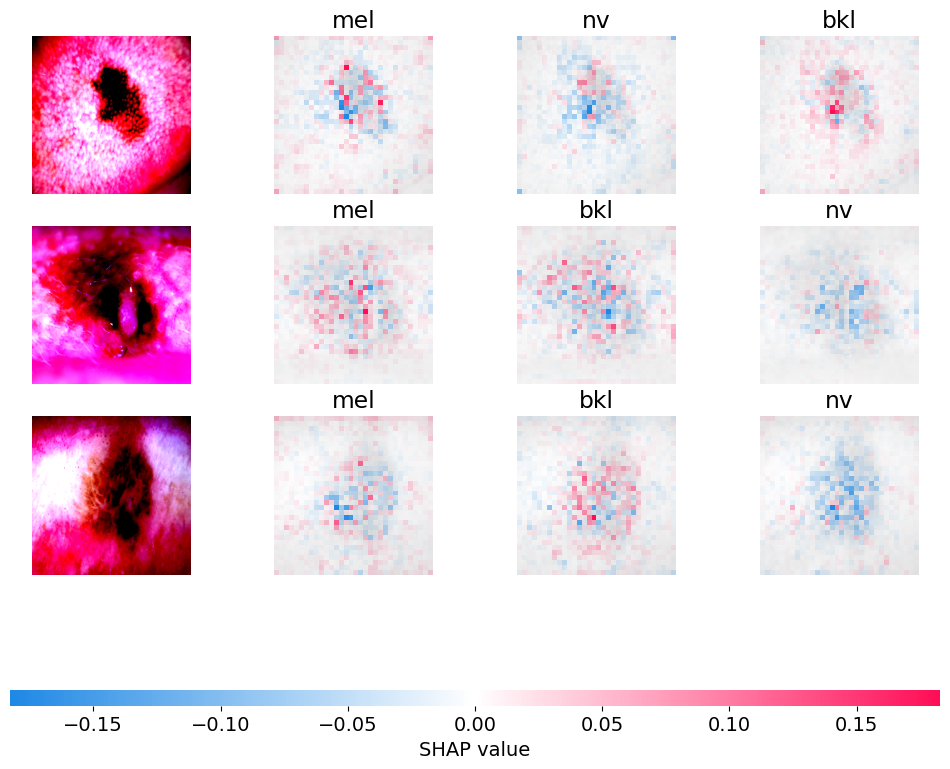

In [20]:
import time
start_time = time.time()
e = shap.GradientExplainer((model_eff, model_eff.net.features[4]), selected_images)
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=3, nsamples=200)
    # get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes)

    # plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
np_to_explain = convert_torch_to_numpy(to_explain)
shap.image_plot(shap_values, np_to_explain, index_names, show=False)
plt.savefig('scratch.png')

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
e = shap.GradientExplainer((model_eff, model_eff.net.features[4]), selected_images)
    



In [104]:
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=3, nsamples=20)

In [18]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

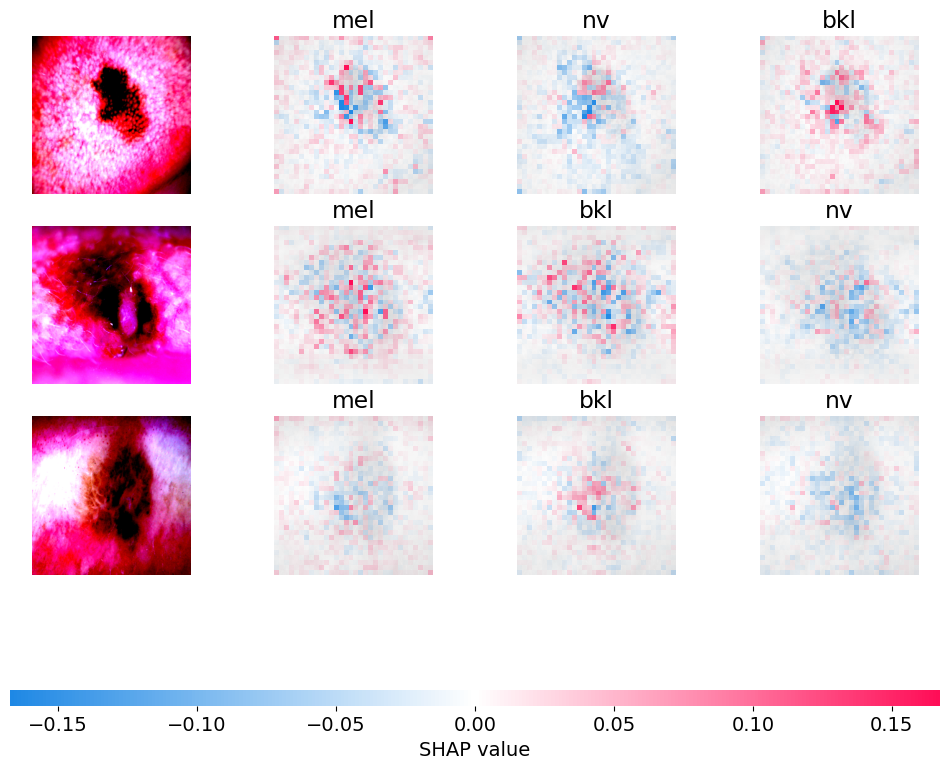

In [101]:
    # get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes)

    # plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
np_to_explain = convert_torch_to_numpy(to_explain)
shap.image_plot(shap_values, np_to_explain, index_names, show=False)
plt.savefig('scratch.png')

In [22]:
#describe model
model_eff

ImageEffNet(
  (net): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

# use captum to explian

In [23]:
pip install captum

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [19]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift,IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [27]:
image1, label1 = test_data[8]
image2, label2 = test_data[2] # xxx1.png from No.2; xxx2.pn from No.8
image3, label3 = test_data[21]
to_explain = torch.cat((image1.unsqueeze(0), image2.unsqueeze(0), image3.unsqueeze(0)), dim=0)
print(type(to_explain))
print(to_explain.shape)

<class 'torch.Tensor'>
torch.Size([3, 3, 256, 256])


In [23]:
input = image1.unsqueeze(0)
input.requires_grad = True

In [47]:
saliency = Saliency(model_eff)
grads = saliency.attribute(input, target=label1)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [21]:
def attribute_image_features(algorithm, input, **kwargs):
    model_eff.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label1,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [50]:
dl = DeepLift(model_eff)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [30]:
input.shape

torch.Size([1, 3, 256, 256])

In [30]:
print('Original Image')

original_image = np.transpose((input.squeeze().cpu().detach().numpy()  / 2) + 0.5, (1, 2, 0))

Original Image


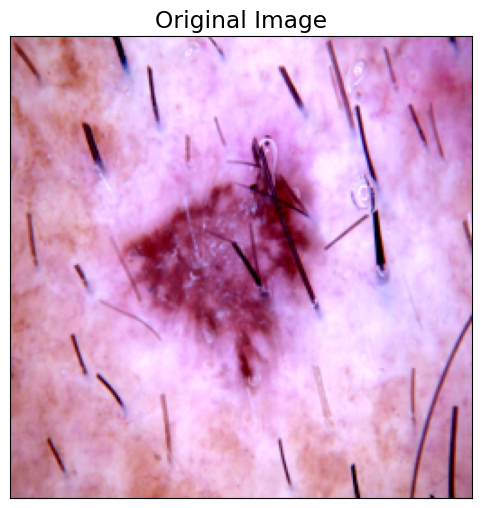

In [52]:


u, _ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

u.savefig('orig_image2.png')

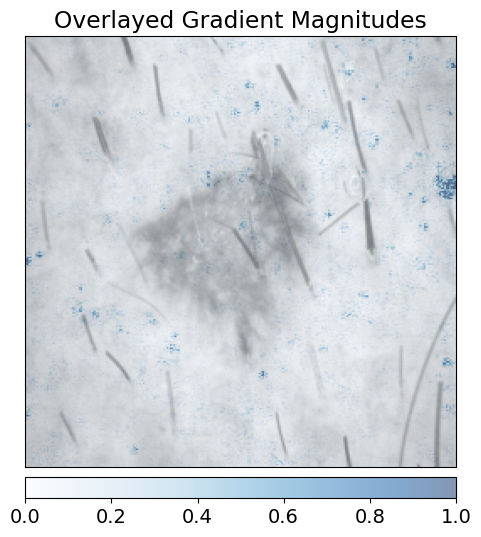

In [53]:
u,_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")
u.savefig('grad2.png')

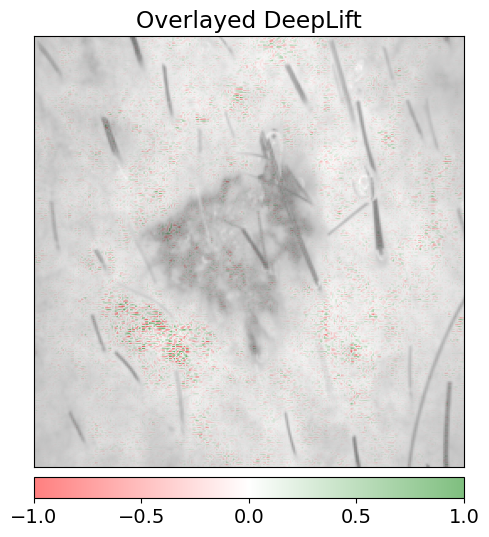

In [54]:
u,_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")
u.savefig('DeepLift2.png')

time calculate

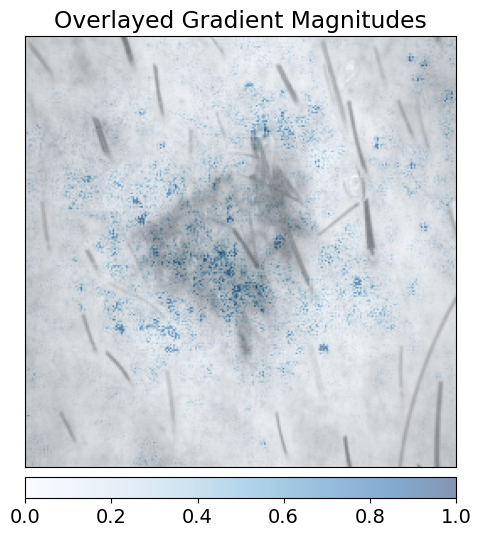

--- 0.5809381008148193 seconds for saliency---
Approximation delta:  tensor([1.4255], dtype=torch.float64)


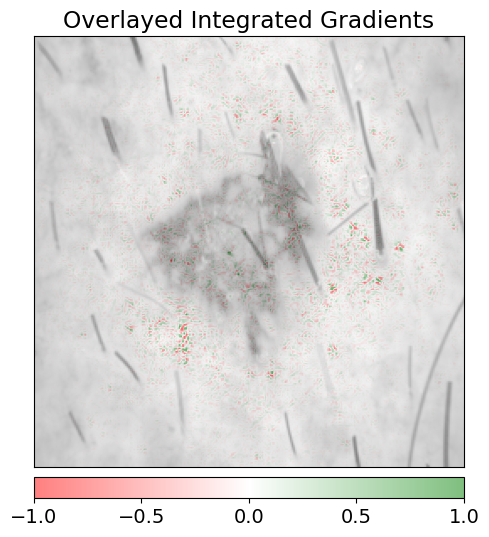

--- 7.381210803985596 seconds for saliency---


In [32]:
def attribute_image_features(algorithm, input, **kwargs):
    model_eff.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label1,
                                              **kwargs
                                             )
    
    return tensor_attributions
import time
start_time = time.time()

saliency = Saliency(model_eff)
grads = saliency.attribute(input, target=label1)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
u,_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

print("--- %s seconds for saliency---" % (time.time() - start_time))


start_time = time.time()
ig = IntegratedGradients(model_eff)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))
_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")
print("--- %s seconds for saliency---" % (time.time() - start_time))

In [ ]:
import time
start_time = time.time()
ig = IntegratedGradients(model_eff)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")
print("--- %s seconds for saliency---" % (time.time() - start_time))

# to get the library process

In [4]:
import torch
from torch.utils.data import DataLoader


In [16]:
class ImageResnet(nn.Module):
    def __init__(self,  output_size, num_classes):
        super(ImageResnet, self).__init__()
        self.net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Modify the last layer to output 7 classes
         #2048
        num_features = self.net.fc.in_features
        self.net.fc = nn.Linear(num_features, output_size)
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

In [17]:
def _get_model_res():
    hidden_size = 128
    output_size = 64
    num_classes = 7
    unet = ImageResnet(output_size, num_classes)

    return unet

In [5]:
def _get_df_data_():
    train_df = pd.read_csv('/kaggle/input/ucidatasplits/train_df.csv').drop(columns=['Unnamed: 0'])
    source = '/kaggle/input/skin-cancer-mnist-ham10000/'

    train_df['image'] = train_df['path'].map(lambda x: transform_train(Image.open(source+x[5:27]+'/'+x[-16:]).convert("RGB")))
 
    return train_df
def get_loder(cut = True):
    train_df = _get_df_data_()

    train_data = dfImageDataset(train_df)
    BATCH_SIZE = 32
    # Data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)

    return train_loader

In [19]:
# Function to load the trained model
def load_model(model_path, modelname, output_size=64, num_classes=7):
    model = ImageResnet(output_size, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [7]:

# Function to register hooks
def register_hooks(model, layers):
    features = {}

    def get_hook(name):
        def hook(module, input, output):
            features[name] = output.detach()
        return hook

    for name, layer in layers.items():
        layer.register_forward_hook(get_hook(name))

    return features


In [8]:
def generate_binary_nearly_orthogonal_matrix(cnm, nm, c, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate a random matrix
    binary_matrix = np.random.randn(cnm, nm)

    total_positions = cnm * nm
    num_ones = total_positions //2
    ones_indices = np.random.choice(total_positions, size=num_ones, replace=False)
    binary_matrix.flat[ones_indices]=1

    return binary_matrix
def process_resnet_features(data, seed=None):
    b, c, n, m = data.shape
    cnm = c * n * m
    nm = n * m

    # Reshape the data
    reshaped_data = data.reshape(b, cnm)

    # Generate the binary nearly orthogonal matrix
    binary_matrix = generate_binary_nearly_orthogonal_matrix(cnm, nm, c,seed=seed)

    # Perform matrix multiplication
    result = np.dot(reshaped_data, binary_matrix)

    return result

In [22]:
# Function to process the data and extract features
def extract_features(data_loader, model, features):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            _ = model(inputs)
            # Flatten and concatenate the features
            layer_features = []
            for key in features:
                layer_features.append(features[key].view(inputs.size(0), -1))
            concatenated_features = torch.cat(layer_features, dim=1)
            all_features.append(concatenated_features)
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)

In [10]:
class dfImageDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['cell_type_idx']

        return image, label

In [24]:

def get_fetures_res(train_loader,model_path = 'res_combine_model_tune.pt'):
    # Load the model and data

    model = load_model(model_path, modelname='resnet')
    # Define the layers to hook
    layers = {
        'layer1': model.net.layer1[1].bn2,
        'layer2': model.net.layer2[1].bn2,
        'layer3': model.net.layer3[1].bn2,
#         'classifier': model.net.fc
    }

    # Register hooks
    features = register_hooks(model, layers)

    import time
    start_time = time.time()
    train_features, train_labels = extract_features(train_loader, model, features)
    print('time cost: ', time.time() - start_time)
    return train_features, train_labels

In [ ]:

loader = get_loder()
print('finish load the data')

In [25]:
model_path ='/kaggle/input/tunedmodel/res_combine_model_tune.pt'
features_, labels_ = get_fetures_res(loader, model_path=model_path)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


time cost:  239.42365145683289
